In [11]:
dir_data = "dataset1"
dir_seg = dir_data + "/annotations_prepped_train/"
dir_img = dir_data + "/images_prepped_train/"

In [12]:
import os
import glob

all_img_paths = glob.glob(os.path.join(dir_img, "*.png"))
print(all_img_paths[:5])

all_mask_paths = glob.glob(os.path.join(dir_seg, "*.png"))
print(all_mask_paths[:5])

['dataset1/images_prepped_train/0001TP_008460.png', 'dataset1/images_prepped_train/0016E5_08490.png', 'dataset1/images_prepped_train/0016E5_06330.png', 'dataset1/images_prepped_train/0006R0_f02550.png', 'dataset1/images_prepped_train/0016E5_02340.png']
['dataset1/annotations_prepped_train/0001TP_008460.png', 'dataset1/annotations_prepped_train/0016E5_08490.png', 'dataset1/annotations_prepped_train/0016E5_06330.png', 'dataset1/annotations_prepped_train/0006R0_f02550.png', 'dataset1/annotations_prepped_train/0016E5_02340.png']


In [13]:
import cv2

x = []
y = []

for i in range(len(all_img_paths)):
    img = cv2.imread(all_img_paths[i])
    img = cv2.resize(img, (224, 224))
    
    mask_path = dir_seg + all_mask_paths[i].split('/')[-1]
    img_mask = cv2.imread(mask_path)
    img_mask = cv2.resize(img_mask, (224, 224))
    
    x.append(img)
    y.append(img_mask)
    
    if (i % 100 == 0):
        print(i)

0
100
200
300


In [14]:
import numpy as np

x = np.array(x)
y = np.array(y)
print(f"X: {x.shape}")
print(f"y: {y.shape}")

X: (367, 224, 224, 3)
y: (367, 224, 224, 3)


(array([72771.,  1059., 47724.,  1275.,   288.,  1509.,   276., 23157.,
          150.,  2319.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

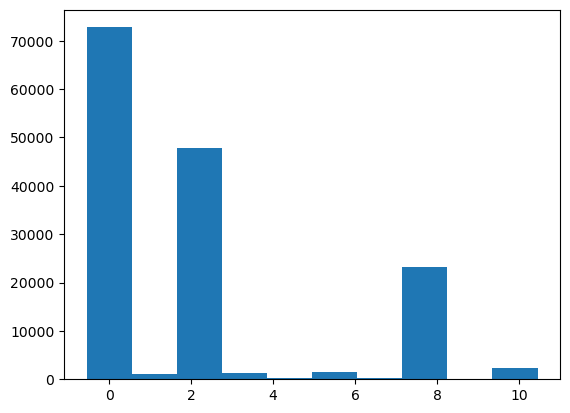

In [15]:
import matplotlib.pyplot as plt

plt.hist(y[2].flatten(), align='left')

In [16]:
y1 = np.where(y==8, 1., 0.) # 8은 자동차 이미지에 masked된 값이므로, 자동차 이미지이면 1.0, 아니면 모두 0.으로 바꾼 것을 y1에 저장
print(y1.shape)

(367, 224, 224, 3)


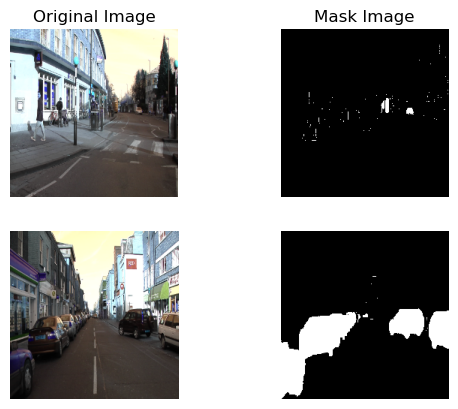

In [17]:
%matplotlib inline

plt.subplot(221)
plt.imshow(x[1])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')

plt.subplot(222)
plt.imshow(y1[1])
plt.axis('off')
plt.title('Mask Image')
plt.grid('off')

plt.subplot(223)
plt.imshow(x[2])
plt.axis('off')
plt.grid('off')

plt.subplot(224)
plt.imshow(y1[2])
plt.axis('off')
plt.grid('off')

plt.show()

In [18]:
x = np.array(x)
y2 = np.array(y1)[:, :, :, 0]
y2 = y2.reshape(y2.shape[0], y2.shape[1], y2.shape[2], 1)

print(y2.shape)

(367, 224, 224, 1)


In [19]:
x = x/255
print(np.max(x))

1.0


In [20]:
from tensorflow.keras.applications.vgg16 import VGG16

base_vgg16 = VGG16(
    include_top=False, input_shape=(224, 224, 3), weights='imagenet'
)
base_vgg16.trainable = False
base_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## VGG16을 이용한 잔차연결

In [26]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Model

In [27]:
conv1 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block1_conv2').output
).output
conv2 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block2_conv2').output
).output
conv3 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block3_conv3').output
).output
conv4 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block4_conv3').output
).output
drop4 = Dropout(0.5)(conv4)
conv5 = Model(
    inputs=base_vgg16.input, outputs=base_vgg16.get_layer('block5_conv3').output
).output
drop5 = Dropout(0.5)(conv5)

In [28]:
up6 = Conv2D(
    512, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=-1)
conv6 = Conv2D(
    512, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge6)
conv6 = Conv2D(
    512, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv6)
conv6 = BatchNormalization()(conv6)

up7 = Conv2D(
    256, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=-1)
conv7 = Conv2D(
    256, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge7)
conv7 = Conv2D(
    256, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv7)
conv7 = BatchNormalization()(conv7)

up8 = Conv2D(
    128, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=-1)
conv8 = Conv2D(
    128, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge8)
conv8 = Conv2D(
    128, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv8)
conv8 = BatchNormalization()(conv8)

up9 = Conv2D(
    64, 2, padding='same', activation='relu', kernel_initializer='he_normal'
)(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=-1)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(merge9)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv9)
conv9 = Conv2D(
    64, 3, padding='same', activation='relu', kernel_initializer='he_normal'
)(conv9)
conv9 = BatchNormalization()(conv9)

conv10 = Conv2D(
    1, 1, activation='sigmoid'
)(conv9)

model = Model(inputs=base_vgg16.input, outputs=conv10)
model.summary() # Non-trainable params: 14,716,608 ( base_vgg16.trainable = False )

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                          

In [29]:
for layer in model.layers[:18]:
    layer.trainable = False

In [30]:
model.compile(
    optimizer=Adam(learning_rate=1e-3, decay=1e-6), loss='binary_crossentropy', metrics=['accuracy']
)

In [31]:
history = model.fit(
    x, y2, epochs=10, batch_size=16, validation_split=0.1, shuffle=True
)

Epoch 1/10


2024-11-19 20:25:42.540490: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


21/21 [==============================] - 85s 4s/step - loss: 0.5947 - accuracy: 0.7762 - val_loss: 49.6973 - val_accuracy: 0.0616
Epoch 2/10
21/21 [==============================] - 83s 4s/step - loss: 0.3214 - accuracy: 0.9642 - val_loss: 8.6197 - val_accuracy: 0.1707
Epoch 3/10
21/21 [==============================] - 83s 4s/step - loss: 0.2182 - accuracy: 0.9696 - val_loss: 1.1035 - val_accuracy: 0.9611
Epoch 4/10
21/21 [==============================] - 84s 4s/step - loss: 0.1642 - accuracy: 0.9759 - val_loss: 0.2460 - val_accuracy: 0.9757
Epoch 5/10
21/21 [==============================] - 86s 4s/step - loss: 0.1233 - accuracy: 0.9794 - val_loss: 0.6940 - val_accuracy: 0.9711
Epoch 6/10
21/21 [==============================] - 85s 4s/step - loss: 0.0999 - accuracy: 0.9814 - val_loss: 0.1848 - val_accuracy: 0.9735
Epoch 7/10
21/21 [==============================] - 87s 4s/step - loss: 0.0830 - accuracy: 0.9827 - val_loss: 0.1216 - val_accuracy: 0.9775
Epoch 8/10
21/21 [============

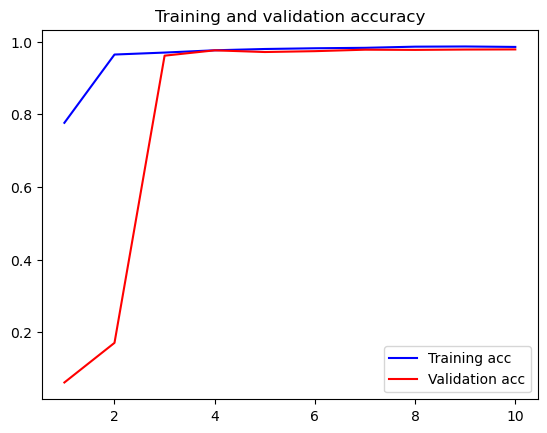

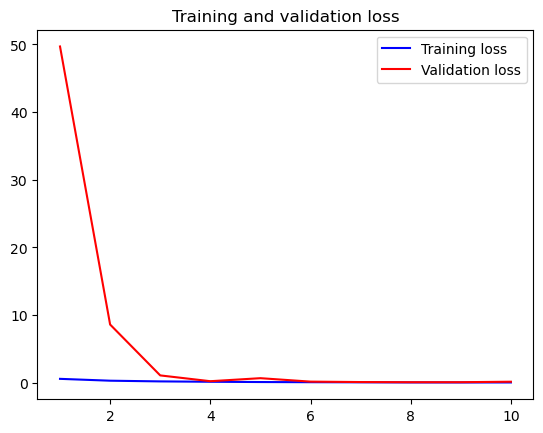

In [34]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [35]:
y_pred = model.predict(x[-2:])
print(y_pred.shape)

1/1 [==============================] - 0s 226ms/step
(2, 224, 224, 1)


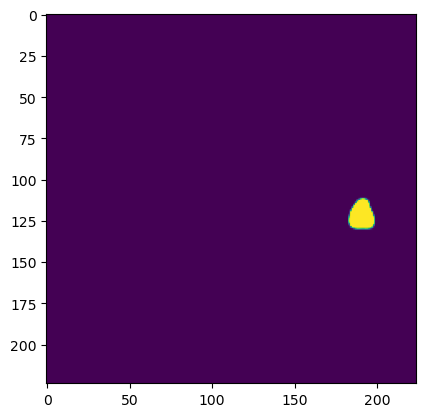

In [36]:
plt.imshow(y_pred[-1,:, :, 0])

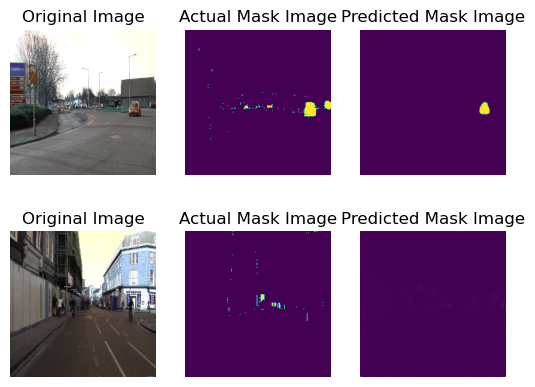

In [38]:
%matplotlib inline

plt.subplot(231)
plt.imshow(x[-1])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')
plt.subplot(232)
plt.imshow(y2[-1,:,:,0])
plt.axis('off')
plt.title('Actual Mask Image')
plt.grid('off')
plt.subplot(233)
plt.imshow(y_pred[-1,:,:,0])
plt.axis('off')
plt.title('Predicted Mask Image')
plt.grid('off')
plt.subplot(234)
plt.imshow(x[-2])
plt.axis('off')
plt.title('Original Image')
plt.grid('off')
plt.subplot(235)
plt.imshow(y2[-2,:,:,0])
plt.axis('off')
plt.title('Actual Mask Image')
plt.grid('off')
plt.subplot(236)
plt.imshow(y_pred[-2,:,:,0])
plt.axis('off')
plt.title('Predicted Mask Image')
plt.grid('off')
plt.show()